<a href="https://colab.research.google.com/github/DanielTaylor97/HonoursProject/blob/master/CNN_MNISTheatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import PIL, PIL.Image
from scipy import signal

DOWNLOADING AND PREPARING THE MNIST DATASET

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)
#reshaping to 60000 and 10000 28*28*1 tensors (1 because b&w)

train_images = train_images/225
test_images = test_images/225
#normalising pixel values

CONVOLUTIONAL BASE STRUCTURE

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1))) #convolution to 26*26*32 tensor
model.add(layers.AveragePooling2D((2, 2))) #pooling to 13*13*32 tensor
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

#model.summary()
##displays the structural information about the network at this point

ADD FULLY CONNECTED LAYERS ON TOP

In [0]:
model.add(layers.Flatten()) #We add another layer which 'flattens' the tensor into a vector
model.add(layers.Dense(64, activation = 'relu')) #fully-connected intermediary layer
model.add(layers.Dense(10, activation = 'softmax')) #softmax output layer

#model.summary()
##remember, parameters listed include biases

MODEL STRUCTURE

In [11]:
#1.    3*3 convolution window: takes 28*28*1 image to 26*26*32 tensor -- relu activation
#2.    2*2 pooling layer: takes 26*26*32 tensor to 13*13*32 tensor
#3.    3*3 convolution window: takes 13*13*32 tensor to 11*11*64 tensor -- relu activation
#4.    2*2 pooling layer: takes 11*11*64 tensor to 5*5*64 tensor
#5.    3*3 convolution window: takes 5*5*64 tensor to 3*3*64 tensor -- relu activation
#6.    flattening layer: takes 3*3*64 tensor to vector of length 576
#7.    fully-connected layer: 64 neurons -- relu activation
#8.    fully-connected layer: 10 neurons -- softmax activation in training model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

COMPILATION AND TRAINING OF THE MODEL

In [12]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy']) #compilation
model.fit(train_images, train_labels, epochs = 5)

Epoch 1/5
60000/60000 [==============================] - 50s 841us/sample - loss: 0.1702 - acc: 0.9488
Epoch 2/5
60000/60000 [==============================] - 51s 842us/sample - loss: 0.0541 - acc: 0.9834
Epoch 3/5
60000/60000 [==============================] - 51s 843us/sample - loss: 0.0394 - acc: 0.9876
Epoch 4/5
60000/60000 [==============================] - 50s 832us/sample - loss: 0.0304 - acc: 0.9901
Epoch 5/5
60000/60000 [==============================] - 49s 825us/sample - loss: 0.0250 - acc: 0.9920


TEST LOSS AND ACCURACY

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 3s 290us/sample - loss: 0.0309 - acc: 0.9903


SAVE PARAMETERS

In [0]:
#model.save_weights(
#    'ccn0_wb.tf',
#    overwrite=True,
#    save_format=None
#)

RUN SOME PREDICTIONS

In [0]:
#test_subset = test_images
#predictions = model.predict(test_subset, steps = 1)

In [0]:
#i = 260
#equiv = True
#sess = tf.Session()
##print(predictions[0, :])
#while equiv:
#  with sess.as_default():
#    prd = tf.argmax(predictions[i]).eval()
#  if test_labels[i] == prd:
#    i = i + 1
#  else:
#    equiv = False
#
#place = i# np.random.randint(0, 9999)
#with sess.as_default():
#  image = tf.reshape(test_subset[place,:,:,:], [28,28]).eval()
#image = image*127.5 + 127.5
##print(image)
#
#plt.imshow(image, cmap = 'gray')
#plt.axis('off')
#plt.show()
##PIL.Image.fromarray(image,'gray')
#
#print('Digit predicted: ', prd)
#print('At place ', i + 1, '. The number is a(n) ', test_labels[i])

SAVE MODEL

In [0]:
model.save('MNISTmodel.h5')

RELOAD OLD MODEL OVER NEW ONE

In [0]:
#new_model = keras.models.load_model('MNISTmodel.h5')

#loss, acc = new_model.evaluate(test_images, test_labels)
#print("Trained model, accuracy: {:5.2f}%".format(100*acc))

HEATMAPS UTILS

In [0]:
#import numpy,PIL,PIL.Image

lowest = -1.0
highest = 1.0

# --------------------------------------
# Sampling data
# --------------------------------------

def getMNISTsample(N=12,seed=None,path=''):

	fx = '%s/t10k-images-idx3-ubyte'%path
	ft = '%s/t10k-labels-idx1-ubyte'%path

	X  = np.fromfile(open(fx),dtype='ubyte',count=16+784*10000)[16:].reshape([10000,784])
	T  = np.fromfile(open(ft),dtype='ubyte',count=8+10000)[8:]
	T  = (T[:,np.newaxis]  == np.arange(10))*1.0

	if seed==None: seed=np.random
	else: seed=np.random.mtrand.RandomState(seed)

	R = seed.randint(0,len(X),[N])
	X,T = X[R],T[R]

	return X/255.0*(highest-lowest)+lowest,T

# --------------------------------------
# Color maps ([-1,1] -> [0,1]^3)
# --------------------------------------

def heatmap(x):

	x = x[...,np.newaxis]

	# positive relevance
	hrp = 0.9 - np.clip(x-0.3,0,0.7)/0.7*0.5
	hgp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4
	hbp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4

	# negative relevance
	hrn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
	hgn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
	hbn = 0.9 - np.clip(-x-0.3,0,0.7)/0.7*0.5

	r = hrp*(x>=0)+hrn*(x<0)
	g = hgp*(x>=0)+hgn*(x<0)
	b = hbp*(x>=0)+hbn*(x<0)

	return np.concatenate([r,g,b],axis=-1)


def graymap(x):

	x = x[...,np.newaxis]
	return np.concatenate([x,x,x],axis=-1)*0.5+0.5

# --------------------------------------
# Visualizing data
# --------------------------------------

def visualize(x,colormap,name):

	N = len(x); assert(N<=16)

	x = colormap(x/np.abs(x).max())

	# Create a mosaic and upsample
	x = x.reshape([1,N,28,28,3])
	x = np.pad(x,((0,0),(0,0),(2,2),(2,2),(0,0)),'constant',constant_values=1)
	x = x.transpose([0,2,1,3,4]).reshape([1*32,N*32,3])
	x = np.kron(x,np.ones([2,2,1]))

	PIL.Image.fromarray((x*255).astype('byte'),'RGB').save(name)

HEATMAPS MODULES

In [0]:
#import numpy

# -------------------------
# Feed-forward network
# -------------------------
class Network:

	def __init__(self,layers):
		self.layers = layers

	def forward(self,Z):
		for l in self.layers: Z = l.forward(Z)
		return Z

	def gradprop(self,DZ):
		for l in self.layers[::-1]: DZ = l.gradprop(DZ)
		return DZ

# -------------------------
# ReLU activation layer
# -------------------------
class ReLU:

	def forward(self,X):
		self.Z = X>0
		return X*self.Z

	def gradprop(self,DY):
		return DY*self.Z

# -------------------------
# Fully-connected layer
# -------------------------
class Linear:

	def __init__(self,name):
		self.W = np.loadtxt(name+'-W.txt')
		self.B = np.loadtxt(name+'-B.txt')

	def forward(self,X):
		self.X = X
		return np.dot(self.X,self.W)+self.B

	def gradprop(self,DY):
		self.DY = DY
		return np.dot(self.DY,self.W.T)

# -------------------------
# Sum-pooling layer
# -------------------------
class Pooling:

	def forward(self,X):
		self.X = X
		self.Y = 0.5*(X[:,::2,::2,:]+X[:,::2,1::2,:]+X[:,1::2,::2,:]+X[:,1::2,1::2,:])
		return self.Y

	def gradprop(self,DY):
		self.DY = DY
		DX = self.X*0
		for i,j in [(0,0),(0,1),(1,0),(1,1)]: DX[:,i::2,j::2,:] += DY*0.5
		return DX

# -------------------------
# Convolution layer
# -------------------------
class Convolution:

	def __init__(self,name):
		wshape = map(int,list(name.split("-")[-1].split("x")))
		self.W = np.loadtxt(name+'-W.txt').reshape(wshape)
		self.B = np.loadtxt(name+'-B.txt')

	def forward(self,X):

		self.X = X
		mb,wx,hx,nx = X.shape
		ww,hw,nx,ny = self.W.shape
		wy,hy       = wx-ww+1,hx-hw+1

		Y = np.zeros([mb,wy,hy,ny],dtype='float32')

		for i in range(ww):
			for j in range(hw):
				Y += np.dot(X[:,i:i+wy,j:j+hy,:],self.W[i,j,:,:])

		return Y+self.B

	def gradprop(self,DY):

		self.DY = DY
		mb,wy,hy,ny = DY.shape
		ww,hw,nx,ny = self.W.shape

		DX = self.X*0

		for i in range(ww):
			for j in range(hw):
				DX[:,i:i+wy,j:j+hy,:] += np.dot(DY,self.W[i,j,:,:].T)

		return DX

In [0]:
##DENSE LAYER FUNCTIONS##

def forward_first(X, W, B):
  return np.matmul(X, W) + B

def relprop_first(X, W, R):
  V = np.maximum(0, W)
  U = np.minimum(0, W)
  L = X*0 + lowest  #vector of the same number -- lower bound
  H = X*0 + highest #vector of the same number -- upper bound
  
  Z = np.matmul(X, W) - np.matmul(L, V) - np.matmul(H, U) + 1e-9
  S = R/Z
  R = X*np.dot(S, W.T) - L*np.dot(S, V.T) - H*np.dot(S, U.T)
  return R
  
def forward_next(X, W, B):
  return np.matmul(X, W) + B

def relprop_next(X, W, R):
  V = np.maximum(0, W)
  Z = np.matmul(X, V) + 1e-9 #we divide by this later -- no division by zero!
  S = R/Z
  C = np.dot(S, V.T)
  R = X*C
  return R
  
def forward_relu(X):
  Z = X>0
  return X*Z

def relprop_relu(R):
  return R


##CONVOLUTION FUNCTIONS##

def forward_conv(X, V, B):
  mb,wx,hx,nx = X.shape
  ww,hw,nx,ny = V.shape
  wy,hy= wx-ww+1,hx-hw+1
  Y = np.zeros([mb,wy,hy,ny],dtype='float32')
  for i in range(ww):
    for j in range(hw):
      Y += np.dot(X[:,i:i+wy,j:j+hy,:],V[i,j,:,:])
  return Y + B

def gradprop_conv(X, W, DY):
  mb,wy,hy,ny = DY.shape
  ww,hw,nx,ny = W.shape
  DX = X*0
  for i in range(ww):
    for j in range(hw):
      DX[:,i:i+wy,j:j+hy,:] += np.dot(DY,W[i,j,:,:].T)
  return DX

def relprop_nextconv(X, W, R):
  V = np.maximum(0, W)
  Z = forward_conv(X, V, 0) + 1e-9
  S = R/Z
  C = gradprop_conv(X, W, S)
  R = X*C
  return R

def relprop_firstconv(X, W, R):
  V = np.maximum(0, W)
  U = np.minimum(0, W)
  
  L = X*0 + lowest
  H = X*0 + highest
  
  Z = forward_conv(X, W, R) - forward_conv(L, V, R) - forward_conv(H, U, R) + 1e-9
  
  S = R/Z
  R = X*gradprop_conv(X, W, S) - L*gradprop_conv(L, V, S) - H*gradprop_conv(H, U, S)
  return R


##POOLING FUNCTIONS##

def forward_pooling(X):
  x = int(2*np.floor(X.shape[1]/2.0))
  y = int(2*np.floor(X.shape[2]/2.0))
  #A[0] = X[:,:x:2,:y:2,:]
  #A[1] = X[:,:x:2,1:y:2,:]
  #A[2] = X[:,1:x:2,:y:2,:]
  #A[3] = X[:,1:x:2,1:y:2,:]
  
  Y = 0.25*(X[:,:x:2,:y:2,:]+X[:,:x:2,1:y:2,:]+X[:,1:x:2,:y:2,:]+X[:,1:x:2,1:y:2,:])
  return Y

def gradprop_pooling(X, DY):
  x = int(2*np.floor(X.shape[1]/2.0))
  y = int(2*np.floor(X.shape[2]/2.0))
  DX = X*0
  for i,j in [(0,0),(0,1),(1,0),(1,1)]: DX[:,i:x:2,j:y:2,:] += DY*0.5
  return DX

def relprop_pooling(X, R):
  Z = forward_pooling(X) + 1e-9
  S = R/Z
  C = gradprop_pooling(X, S)
  R = X*C
  return R


##RELU FUNCTIONS##

def forward_relu(X):
  Z = X>0
  return X*Z

def relprop_relu(R):
  return R

IMPLEMENTING HEATMAPPINGS

In [50]:
map_model = models.Sequential()
map_model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1))) #convolution to 26*26*32 tensor
map_model.add(layers.AveragePooling2D((2, 2))) #pooling to 13*13*32 tensor
map_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
map_model.add(layers.AveragePooling2D((2, 2)))
map_model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

map_model.add(layers.Flatten()) #We add another layer which 'flattens' the tensor into a vector
map_model.add(layers.Dense(64, activation = 'relu')) #fully-connected intermediary layer
map_model.add(layers.Dense(10))

#model.summary()
#print()
#map_model.summary()

#map_model.set_weights(model.get_weights())
map_model = keras.models.load_model('MNISTmapmodel.h5')
#mapping model is the same as the original trained model, but with no softmax activation in the final layer

W0823 18:49:10.882965 139834315306880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 18:49:10.886118 139834315306880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0823 18:49:11.215407 139834315306880 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [0]:
N = 12
positions = np.random.randint(0, 10000, size = (N,))
X, L = test_images[:N, :, :], test_labels[:N]

In [52]:
n = 0
sess = tf.Session()

images_to_map = np.empty(shape = (1, 28, 28, 1))
L_itm = np.empty(shape = (1))

for i in range(0, N):
  X[i, :, :, :] = test_images[positions[i], :, :, :]
  L[i] = test_labels[positions[i]]
  with sess.as_default():
    img = tf.reshape(X[i], [28, 28]).eval()
  #plt.imshow(img, cmap = 'gray')
  #plt.axis('off')
  one_prediction = map_model.predict(X[i:(i + 1), :, :, :])
  decision = np.argmax(one_prediction)
  if decision == L[i]:
    #print(decision)
    #print(one_prediction)
    #plt.show()
    n += 1
    images_to_map = np.append(images_to_map, X[i:(i + 1), :, :, :], axis = 0)
    L_itm = np.append(L_itm, L[i:(i + 1)], axis = 0)
  else:
    print('!!! decision {} not equal to value {} !!!'.format(decision, L[i]))

images_to_map = np.delete(images_to_map, 0, 0)
L_itm = np.delete(L_itm, 0, 0)
print()
print('Shape of images array: {}'.format(images_to_map.shape))

print('Total number of acceptable examples: {}/{}'.format(n, N))


Shape of images array: (12, 28, 28, 1)
Total number of acceptable examples: 12/12


In [0]:
map_model.summary()

In [0]:
CW1 = np.asarray(map_model.get_weights()[0]) #3*3*32 list of weights --> array, taking input to 26*26*32 tensor
CW2 = np.asarray(map_model.get_weights()[2]) #3*3*32*64 list of weights --> array, taking 13*13*32 pooled tensor to 11*11*64 tensor
CW3 = np.asarray(map_model.get_weights()[4]) #3*3*64*64 list of weights --> array, taking 5*5*64 pooled tensor to 3*3*64 tensor

CB1 = np.asarray(map_model.get_weights()[1]) #First convolutional layer's 32 biases --> array
CB2 = np.asarray(map_model.get_weights()[3]) #Second convolutional layer's 64 biases --> array
CB3 = np.asarray(map_model.get_weights()[5]) #Third convolutional layer's 64 biases --> array

DW1 = np.asarray(map_model.get_weights()[6]) #576*64 list of weights --> array, taking 3*3*64 array (flattened tensor) to 64 nodes
DW2 = np.asarray(map_model.get_weights()[8]) #64*10 list of weights --> array, taking 64 nodes to 10 nodes

DB1 = np.asarray(map_model.get_weights()[7]) #First dense layer's 64 biases --> array
DB2 = np.asarray(map_model.get_weights()[9]) #Second dense layer's 10 biases --> array


##LAYERS STRUCTURE##

#1.    3*3 convolution window: takes 28*28*1 image to 26*26*32 tensor -- relu activation       CW1, CB1
#2.    2*2 pooling layer: takes 26*26*32 tensor to 13*13*32 tensor
#3.    3*3 convolution window: takes 13*13*32 tensor to 11*11*64 tensor -- relu activation     CW2, CB2
#4.    2*2 pooling layer: takes 11*11*64 tensor to 5*5*64 tensor
#5.    3*3 convolution window: takes 5*5*64 tensor to 3*3*64 tensor -- relu activation         CW3, CB3
#6.    flattening layer: takes 3*3*64 tensor to vector of length 576
#7.    fully-connected layer: 64 neurons -- relu activation                                    DW1, DB1
#8.    fully-connected layer: 10 neurons -- softmax activation in training model               DW2, DB2

0.0


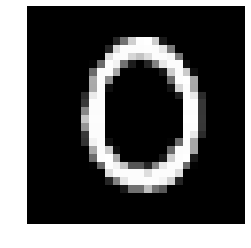

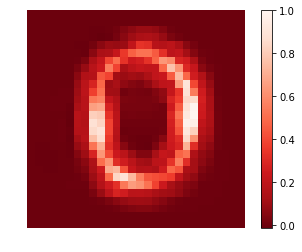

0.0


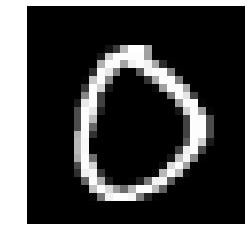

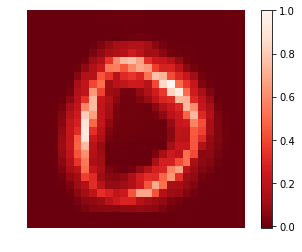

0.0


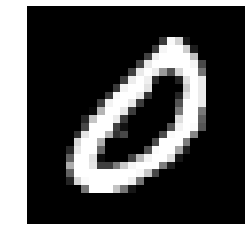

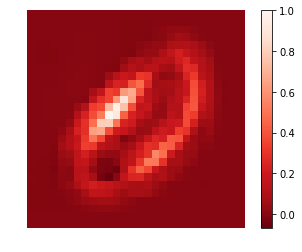

8.0


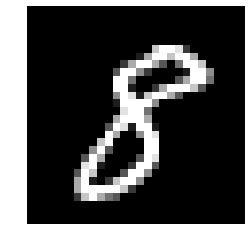

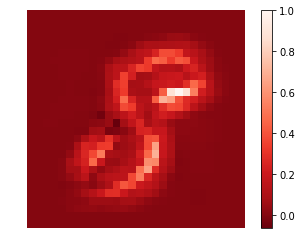

1.0


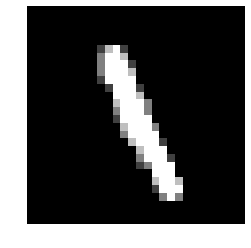

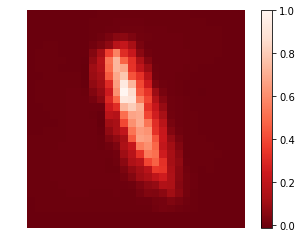

1.0


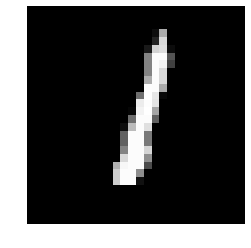

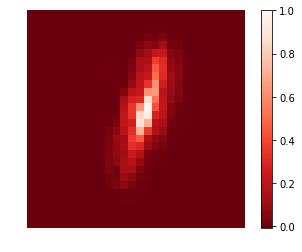

0.0


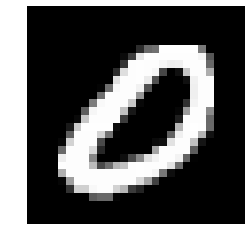

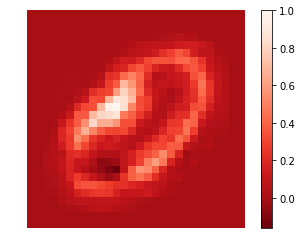

3.0


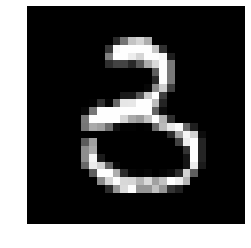

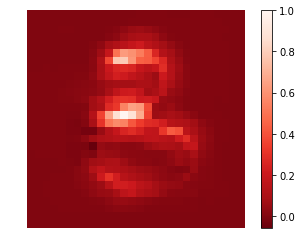

0.0


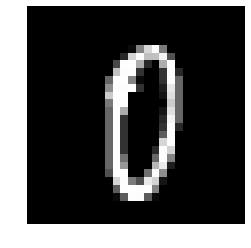

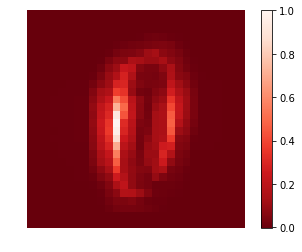

6.0


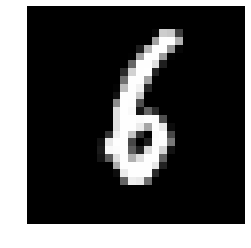

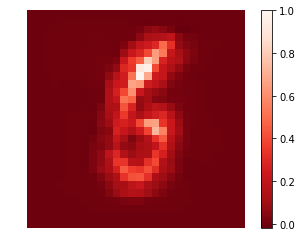

2.0


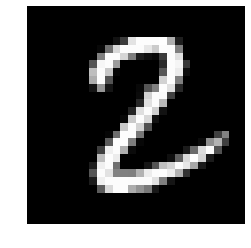

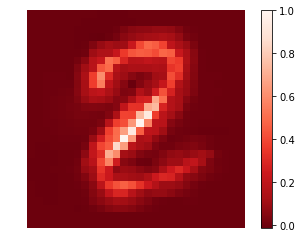

9.0


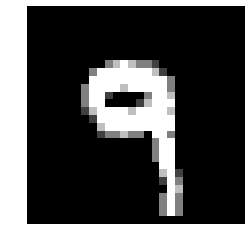

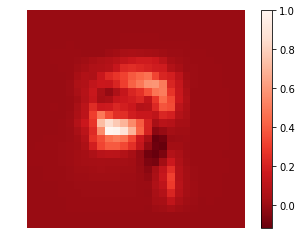

In [54]:
X0 = np.zeros((1, 28, 28, 1))
X1 = np.zeros((1, 26, 26, 32))
Relu1 = np.zeros((1, 26, 26, 32))
X2 = np.zeros((1, 13, 13, 32))
X3 = np.zeros((1, 11, 11, 64))
Relu3 = np.zeros((1, 11, 11, 64))
X4 = np.zeros((1, 5, 5, 64))
X5 = np.zeros((1, 3, 3, 64))
Relu5 = np.zeros((1, 3, 3, 64))
X6 = np.zeros(576)
X7 = np.zeros(64)
Relu7 = np.zeros(64)
X8 = np.zeros(10)

R = np.zeros(10)

LK = np.zeros((n, 10))
#print(L)
for j in range(0, n):
  LK[j, :] = signal.unit_impulse(10, L[j])
#print(LK)

for k in range(0, n):
  X0 = images_to_map[k:(k + 1), :, :, :]
  X1 = forward_conv(X0, CW1, CB1)
  Relu1 = forward_relu(X1)
  X2 = forward_pooling(Relu1)
  X3 = forward_conv(X2, CW2, CB2)
  Relu3 = forward_relu(X3)
  X4 = forward_pooling(Relu3)
  X5 = forward_conv(X4, CW3, CB3)
  Relu5 = forward_relu(X5)
  X6 = np.reshape(Relu5, (576))
  X7 = forward_next(X6, DW1, DB1)
  Relu7 = forward_relu(X7)
  X8 = forward_next(Relu7, DW2, DB2)
  
  R = X8*0
  R[int(np.argmax(X8))] = np.dot(X8, LK[k, :])
  #R = X8
  
  #R = relprop_relu(R)                 #8.
  ##print(R.shape)
  R = relprop_next(X7, DW2, R)        #7.b
  #print(R.shape)
  R = relprop_next(X6, DW1, R)        #7.a
  #print(R.shape)
  R = np.reshape(R, (1, 3, 3, 64))    #6
  #print(R.shape)
  #R = relprop_relu(R)                 #5.b
  ##print(R.shape)
  R = relprop_nextconv(X4, CW3, R)    #5.a
  #print(R.shape)
  R = relprop_pooling(Relu3, R)       #4
  #print(R.shape)
  #R = relprop_relu(R)                 #3.b
  ##print(R.shape)
  R = relprop_nextconv(X2, CW2, R)    #3.a
  #print(R.shape)
  R = relprop_pooling(Relu1, R)       #2
  #print(R.shape)
  #R = relprop_relu(R)                 #1.b
  ##print(R.shape)
  R = relprop_firstconv(X0, CW1, R)   #1.a
  #print(R.shape)
  
  R.shape = (28*28)
  r = np.max(R)
  
  R.shape = (28, 28)
  print(L_itm[k])
  plt.imshow(images_to_map[k, :, :, 0], cmap = 'gray')
  plt.axis('off')
  plt.show()
  plt.imshow(R/r, cmap = 'Reds_r')
  plt.axis('off')
  plt.colorbar()#ticks = [])
  plt.show()
  
  #fig, (ax1, ax2) = plt.subplots(figsize=(13, 3))
  #num = ax1.imshow(images_to_map[k, :, :, 0], cmap = 'gray')
  #hm = ax2.imshow(R, cmap = 'Reds_r')
  #fig.colorbar(ax=ax2)
  
  
##LAYERS STRUCTURE##

#1.    3*3 convolution window: takes 28*28*1 image to 26*26*32 tensor -- relu activation       CW1, CB1    X0    a--> X1 b--> Relu1
#2.    2*2 pooling layer: takes 26*26*32 tensor to 13*13*32 tensor                                         Relu1  --> X2
#3.    3*3 convolution window: takes 13*13*32 tensor to 11*11*64 tensor -- relu activation     CW2, CB2    X2    a--> X3 b--> Relu3
#4.    2*2 pooling layer: takes 11*11*64 tensor to 5*5*64 tensor                                           Relu3  --> X4
#5.    3*3 convolution window: takes 5*5*64 tensor to 3*3*64 tensor -- relu activation         CW3, CB3    X4    a--> X5 b--> Relu5
#6.    flattening layer: takes 3*3*64 tensor to vector of length 576                                       Relu5  --> X6
#7.    fully-connected layer: 64 neurons -- relu activation                                    DW1, DB1    X6    a--> X7 b--> Relu7
#8.    fully-connected layer: 10 neurons -- softmax activation in training model               DW2, DB2    Relu7 --> X8

4.0


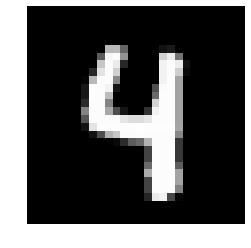

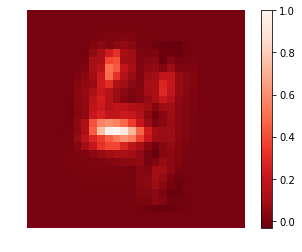

3


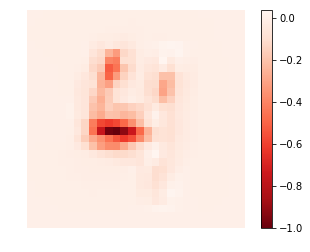



4.0


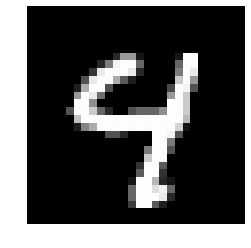

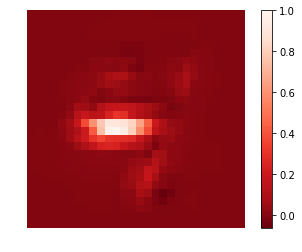

6


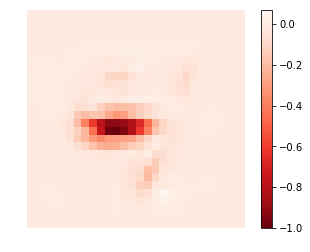



3.0


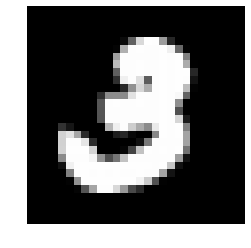

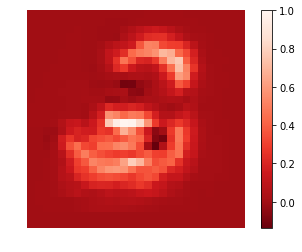

6


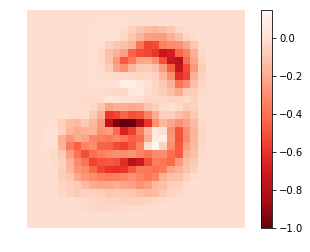



7.0


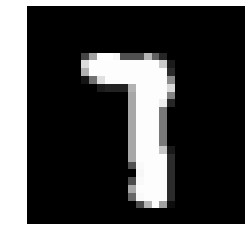

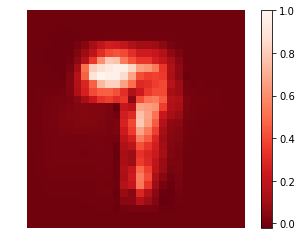

6


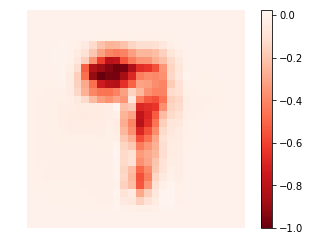



6.0


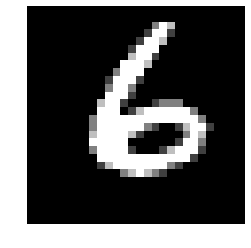

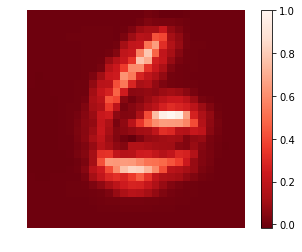

7


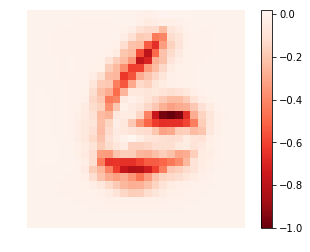



2.0


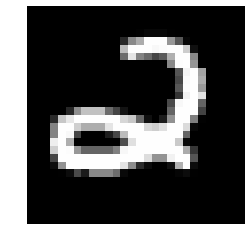

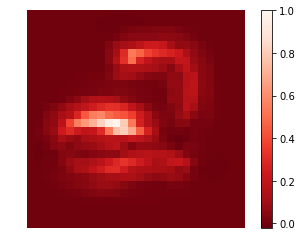

6


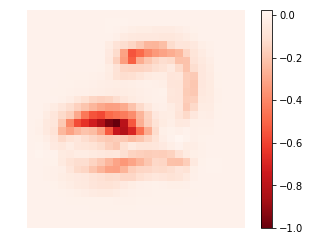



8.0


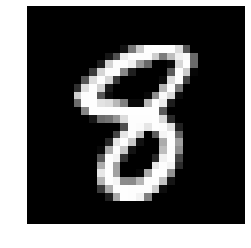

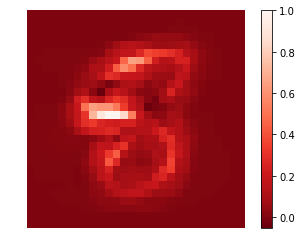

4


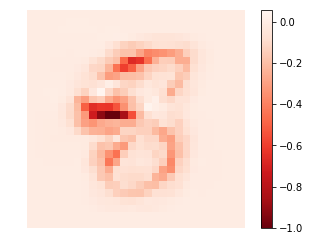



7.0


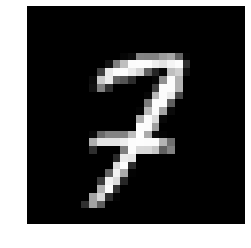

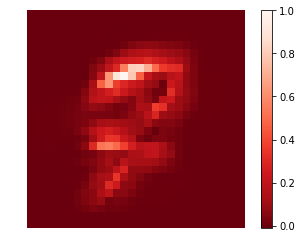

6


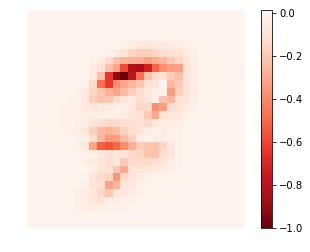



9.0


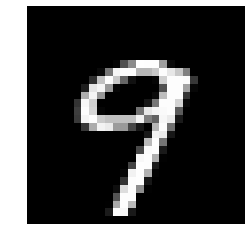

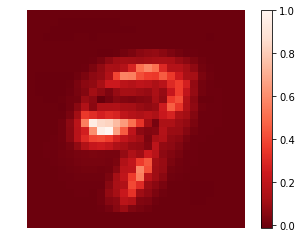

6


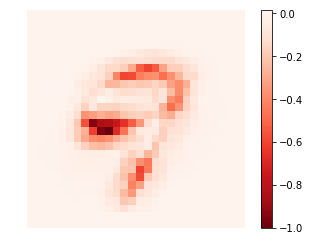



6.0


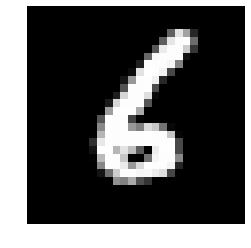

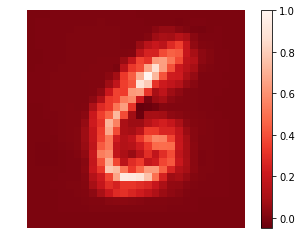

7


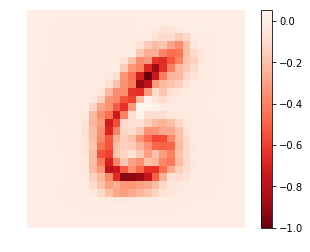



9.0


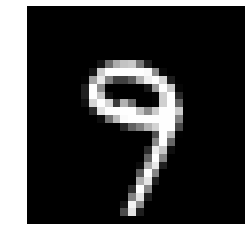

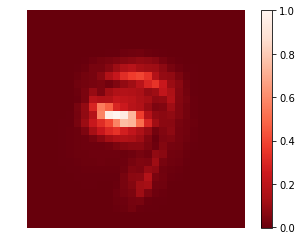

6


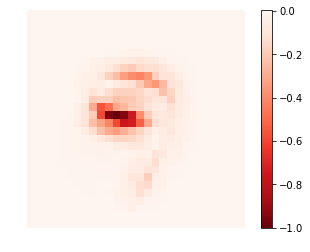



7.0


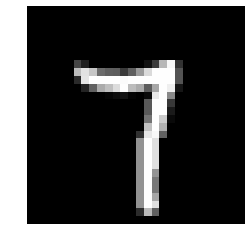

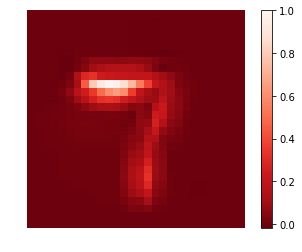

6


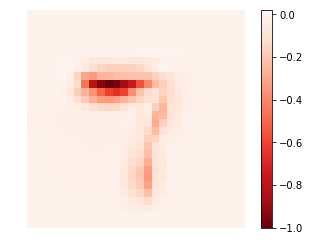

In [32]:
LK_opp = np.zeros((n, 10))

for k in range(0, n):
  X0 = images_to_map[k:(k + 1), :, :, :]
  X1 = forward_conv(X0, CW1, CB1)
  Relu1 = forward_relu(X1)
  X2 = forward_pooling(Relu1)
  X3 = forward_conv(X2, CW2, CB2)
  Relu3 = forward_relu(X3)
  X4 = forward_pooling(Relu3)
  X5 = forward_conv(X4, CW3, CB3)
  Relu5 = forward_relu(X5)
  X6 = np.reshape(Relu5, (576))
  X7 = forward_next(X6, DW1, DB1)
  Relu7 = forward_relu(X7)
  X8 = forward_next(Relu7, DW2, DB2)
  
  LK_opp[k, :] = signal.unit_impulse(10, np.argmax(-X8))
  
  R = X8*0
  R_opp = X8*0
  R[int(np.argmax(X8))] = np.dot(X8, LK[k, :])
  R_opp[int(np.argmax(X8))] = np.dot(X8, LK_opp[k, :])
  #R_opp = R_opp - R
  
  R_opp = relprop_next(X7, DW2, R_opp)        #7.b
  R_opp = relprop_next(X6, DW1, R_opp)        #7.a
  R_opp = np.reshape(R_opp, (1, 3, 3, 64))    #6
  R_opp = relprop_nextconv(X4, CW3, R_opp)    #5.a
  R_opp = relprop_pooling(Relu3, R_opp)       #4
  R_opp = relprop_nextconv(X2, CW2, R_opp)    #3.a
  R_opp = relprop_pooling(Relu1, R_opp)       #2
  R_opp = relprop_firstconv(X0, CW1, R_opp)   #1.a
  
  R = relprop_next(X7, DW2, R)        #7.b
  R = relprop_next(X6, DW1, R)        #7.a
  R = np.reshape(R, (1, 3, 3, 64))    #6
  R = relprop_nextconv(X4, CW3, R)    #5.a
  R = relprop_pooling(Relu3, R)       #4
  R = relprop_nextconv(X2, CW2, R)    #3.a
  R = relprop_pooling(Relu1, R)       #2
  R = relprop_firstconv(X0, CW1, R)   #1.a
  
  R.shape = (28*28)
  R_opp.shape = (28*28)
  r = np.max(R)
  r_opp = np.abs(np.min(R_opp))
  
  R_opp.shape = (28, 28)
  R.shape = (28, 28)
  print(L_itm[k])
  plt.imshow(images_to_map[k, :, :, 0], cmap = 'gray')
  plt.axis('off')
  plt.savefig('gmap{}'.format(k))
  plt.show()
  plt.imshow(R/r, cmap = 'Reds_r')
  plt.axis('off')
  plt.colorbar()#ticks = [])
  plt.savefig('hmap{}'.format(k))
  plt.show()
  print(np.argmax(LK_opp[k, :]))
  plt.imshow(R_opp/r_opp, cmap = 'Reds_r')
  plt.axis('off')
  plt.colorbar()#ticks = [])
  plt.savefig('nhmap{}'.format(k))
  plt.show()
  print()
  print()

DOWNLOAD SAVED FILES

In [37]:
from google.colab import files

print(n)

for m in range(0, n):
  #files.download('gmap{}.png'.format(m))
  #files.download('hmap{}.png'.format(m))
  #files.download('nhmap{}.png'.format(m))

12


In [0]:
map_model.save('MNISTmapmodel.h5')

EXAMINING HEATMAP FOR INCORRECT PREDICTION

!!!5 not equal to 3, at place 449!!!
3


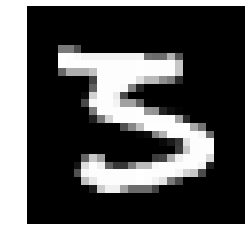

[[-12.11444     -4.7581325   -7.431087    11.55553     -8.077193
   11.6883745   -8.687086   -11.179525    -2.133932    -0.74100417]]


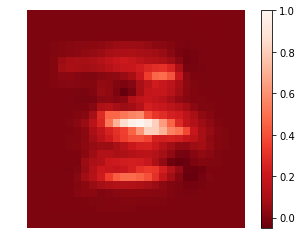

In [73]:
counter = 448
falsepred = False

while counter < 10000 and falsepred == False:
  one_prediction = map_model.predict(test_images[counter:(counter + 1), :, :, :])
  decision = np.argmax(one_prediction)
  if decision != test_labels[counter]:
    print('!!!{} not equal to {}, at place {}!!!'.format(decision, test_labels[counter], counter))
    falsepred = True
  counter += 1

#print(one_prediction)

X0 = test_images[(counter - 1):counter, :, :, :]
X1 = forward_conv(X0, CW1, CB1)
Relu1 = forward_relu(X1)
X2 = forward_pooling(Relu1)
X3 = forward_conv(X2, CW2, CB2)
Relu3 = forward_relu(X3)
X4 = forward_pooling(Relu3)
X5 = forward_conv(X4, CW3, CB3)
Relu5 = forward_relu(X5)
X6 = np.reshape(Relu5, (576))
X7 = forward_next(X6, DW1, DB1)
Relu7 = forward_relu(X7)
X8 = forward_next(Relu7, DW2, DB2)

R = X8*0
R[int(np.argmax(X8))] = one_prediction[0, int(np.argmax(X8))]#np.dot(X8, LK[k, :])

R = relprop_next(X7, DW2, R)        #7.b
R = relprop_next(X6, DW1, R)        #7.a
R = np.reshape(R, (1, 3, 3, 64))    #6
R = relprop_nextconv(X4, CW3, R)    #5.a
R = relprop_pooling(Relu3, R)       #4
R = relprop_nextconv(X2, CW2, R)    #3.a
R = relprop_pooling(Relu1, R)       #2
R = relprop_firstconv(X0, CW1, R)   #1.a

R.shape = (28*28)
r = np.max(R)

R.shape = (28, 28)
print(test_labels[counter - 1])
plt.imshow(test_images[counter - 1, :, :, 0], cmap = 'gray')
plt.axis('off')
plt.savefig('gmap_false')
plt.show()
print(one_prediction)
plt.imshow(R/r, cmap = 'Reds_r')
plt.axis('off')
plt.colorbar()#ticks = [])
plt.savefig('hmap_false')
plt.show()

In [0]:
from google.colab import files

files.download('gmap_false.png')
files.download('hmap_false.png')